In [29]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## For generating samples:
- In each simulation, stocks are sharing the same T-p Factor matrix.

In [37]:
N = 1000
p = 300
T = 120
idiovol_sigma = np.sqrt(0.3*0.3/12)
e_mu = np.sqrt(0.2*0.2/12)
e_sigma = e_mu
mu = 0.1/12/e_mu
w0 = np.zeros(N) # for now
returns = []

gamma = 1
c = 1
a = 1.5
b = 1.5
# values_new = []

values_new = []

# X
factors = []
# y
y = []

utility_avg = []
for s in range(100): # can change the simulation number
    beta = np.zeros((N,p)) 
    beta[:,0] = np.random.normal(e_mu, e_sigma, N)
    mus = np.zeros((N,p))
    mus[:,0] = mu
    returns = []
    f = np.random.multivariate_normal(np.zeros(p), np.identity(p), T) #share the same T*p matrix
    
    for j in range(1,p):
        beta[:,j-1] = beta[:,0]*j**(-a)  # draw an N*p matrix of beta
        mus[:,j-1] = mu*j**(-b)  # draw an N*p matrix of mus
        alpha = (beta * mus).sum(axis = 1) # get the factor risk premia
        
    for stock in range(N):
         # for each stock generate the factor matrix
        epsilon = np.random.normal(0,idiovol_sigma,T) #generate the residuals
        r = alpha[stock] + np.array(beta[stock]).T @ f.T + epsilon # calculate the return series for each stock
        returns.append(r.T)
    factors.append(f)
    

    y.append(returns) 

In [36]:
np.shape(y)

(5, 1000, 120)

In [38]:
lambdas = np.geomspace(0.1,100,30)


utility_avg = []

for l in lambdas:
    value_l = []
    for s in range(np.shape(y)[0]):
        beta_hat_stocks = []
        alpha_hat_stocks = []
        sigma_ridge = []
        for stock in range(N):
        #             ridge_betas = ridge_closed(factors[s][stock], y[s][stock], l)[0]
        #             ridge_intercept = ridge_closed(factors[s][stock], y[s][stock], l)[1]
            ridge = Ridge(alpha = l, fit_intercept = True).fit(factors[s], y[s][stock])

            beta_hat_stocks.append(ridge.coef_)
            alpha_hat_stocks.append(ridge.intercept_)
            sigma_ridge.append(np.var(y[s][stock] - ridge.intercept_ - ridge.coef_ @ factors[s].T))
        sigma_hat = np.array(beta_hat_stocks) @ np.array(beta_hat_stocks).T + sigma_ridge @ np.identity(N)
        weights = np.linalg.inv(gamma * sigma_hat + c * np.identity(N)) @ (alpha_hat_stocks + c * w0)
        sigma_true = beta @ beta.T + np.identity(N)*idiovol_sigma**2 
        value = weights.T @ alpha - 0.5*gamma*weights.T @ sigma_true @ weights - 0.5*c*np.sqrt(sum((weights - w0)**2))
        value_l.append(value)
    utility_avg.append(np.mean(value_l))

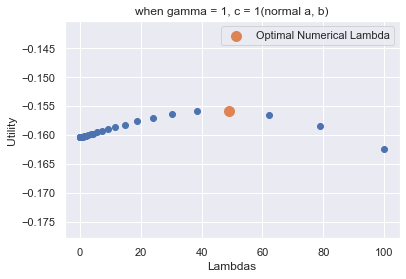

In [39]:
plt.scatter(y = utility_avg, x = lambdas)

plt.ylabel('Utility')
plt.xlabel('Lambdas')
plt.title('when gamma = 1, c = 1(normal a, b)')


plt.scatter(y = max(utility_avg), x = lambdas[np.argmax(utility_avg)],s=100, label = 'Optimal Numerical Lambda')
plt.legend()

In [40]:
lambdas[np.argmax(utility_avg)]

48.93900918477494

## Statistical $\lambda$

In [41]:
stats_lambda = (N*(p+1)*idiovol_sigma**2)/((sum(alpha**2)+sum(sum(beta**2)))*T)

stats_lambda

2.3250898936549387

In [42]:
# interpolate the curve of utility vs lambdas
from scipy.interpolate import interp1d

func = interp1d(lambdas, utility_avg, kind = 'cubic', fill_value='extrapolate')

## Economic $\lambda$ : check its calculation again

In [43]:
mu_f = mus[0]
sigma_bar = gamma * sigma_true + c*np.identity(N)
sigma_bar_v = np.linalg.inv(sigma_bar)
B1 = sigma_bar_v.trace()
M = beta @ mu_f + c*w0

B2 = B1*M.T @ sigma_bar_v @ beta @ beta.T @ sigma_bar_v @ M
beta_b_beta = beta.T @ sigma_bar_v @ beta
B3 = gamma**2 * beta_b_beta.trace()*M.T @ sigma_bar_v @ sigma_bar_v @ M
B4 = 2*gamma**2 * M.T @ sigma_bar_v @ sigma_bar_v @ beta @ beta.T @ sigma_bar_v @ M

M_f = beta @ mu_f + 2*gamma*beta@beta.T @sigma_bar_v@M

denominator = M_f.T @ sigma_bar_v @ M_f

eml = ((idiovol_sigma**2)/T)*((B1+B2+B3+B4)/denominator)
eml

0.369927802065763

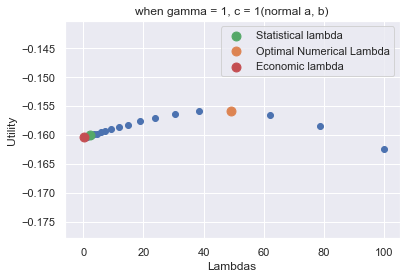

In [45]:
plt.scatter(y = utility_avg, x = lambdas)
plt.scatter(y = func(stats_lambda), x = stats_lambda, marker='o',label = 'Statistical lambda', c = 'g',s=80)
plt.scatter(y = max(utility_avg), x = lambdas[np.argmax(utility_avg)],label = 'Optimal Numerical Lambda',s=80)
plt.scatter(y = func(eml), x = eml, label = 'Economic lambda', c='r',s=80)
plt.ylabel('Utility')
plt.xlabel('Lambdas')
plt.title('when gamma = 1, c = 1(normal a, b)')
plt.legend()